In [1]:
import os
from os import listdir
from tqdm import tqdm

import cv2
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
# import albumentations as A

from PIL import Image
import matplotlib.pyplot as plt

import wandb
import mlflow

### Preprocessing & EDA (sort of)

Let us see what we have here.

In [2]:
folders = ['raw_data/santa_rosa/', 'raw_data/ventura/']

In [3]:
inputs, targets = [], []

for folder in folders:
    aggregated_input = []
    for image_path in [folder+f for f in listdir(folder) if '.tif' in f]:
        image = plt.imread(image_path)
        if 'all' in image_path:  
            targets.append(image)
            print(f'Target image {image_path} shape is {targets[-1].shape}')
        else:
            aggregated_input.append(image[:, :, np.newaxis])
            print(f'Input image {image_path} shape is {aggregated_input[-1].shape}')
    inputs.append(np.concatenate(aggregated_input, axis=2))

Input image raw_data/santa_rosa/GRN.tif shape is (2160, 2148, 1)
Input image raw_data/santa_rosa/RED.tif shape is (2160, 2148, 1)
Input image raw_data/santa_rosa/BLUE.tif shape is (2160, 2148, 1)
Target image raw_data/santa_rosa/all.tif shape is (2160, 2148, 4)
Input image raw_data/ventura/GRN.tif shape is (4418, 4573, 1)
Input image raw_data/ventura/RED.tif shape is (4418, 4573, 1)
Input image raw_data/ventura/BLUE.tif shape is (4418, 4573, 1)
Target image raw_data/ventura/all.tif shape is (4418, 4573, 4)


Everything is consistent, W and H dimensions of input-target pairs are aligned. Since the input channels were separated, we merged them back together.

Provided segmentation masks have four channels which seems to be a bit more than expected. Let us ensure that they are identical:

In [4]:
[[(targets[i][:, :, 0] == targets[i][:, :, j]).all() for j in range(4)] for i in range(len(targets))] 

[[True, True, True, False], [True, True, True, False]]

First three channels of both images are the same while the last one is empty (hence we can freely discard it):

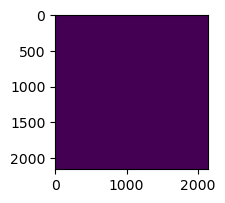

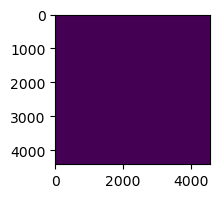

In [5]:
for i in range(len(targets)):
    fig = plt.figure(figsize=(2, 2))
    plt.imshow(targets[i][:, :, 3])
    plt.show()

In [6]:
targets = [target_image[:, :, :3] for target_image in targets]

As we can see, the images are too large to be processed. To handle that, we are going to construct the grid and distribute obtained patches between train/val/test sets.

In [7]:
def img_2_grid(img: np.array, patch_size: int) -> list:
    patches = [
        img[x:x+patch_size, y:y+patch_size] 
        for x in range(0, patch_size*np.floor(img.shape[0]/patch_size).astype('int'), patch_size) 
        for y in range(0, patch_size*np.floor(img.shape[1]/patch_size).astype('int'), patch_size)
    ]
    return patches

In [8]:
PATCH_SIZE = 224

In [9]:
inputs_s, targets_s = [], []

for input_image, target_image in zip(inputs, targets):
    inputs_s += img_2_grid(input_image, PATCH_SIZE)
    targets_s += img_2_grid(target_image, PATCH_SIZE)

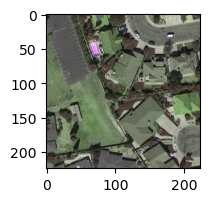

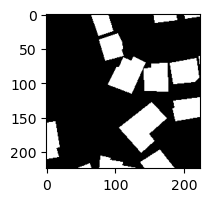

In [10]:
i = 460

fig = plt.figure(figsize=(2, 2))
plt.imshow(inputs_s[i])
plt.show()

fig = plt.figure(figsize=(2, 2))
plt.imshow(targets_s[i])
plt.show()

Why 224? Just because it is a standard input size for most of the image encoders (by the way, I know that it can be done as part of a transformation pipeline).  

As far as I can see, there are no critical relations between different patches => no data leakage => no specific requirements for train/val/test split.

In [11]:
train_imgs, val_imgs, train_targets, val_targets = train_test_split(inputs_s, targets_s, train_size=0.7)
val_imgs, test_imgs, val_targets, test_targets = train_test_split(val_imgs, val_targets, train_size=0.5)

print(f'Train sample size {len(train_imgs)}; validation sample size {len(val_imgs)}; test sample size {len(test_imgs)}')

Train sample size 322; validation sample size 69; test sample size 70


In [15]:
os.makedirs('processed_data', exist_ok=True)
for folder_s in ['train', 'val', 'test']:
    os.makedirs(f'processed_data/{folder_s}', exist_ok=True)
    for folder_t in ['images', 'masks']:
        os.makedirs(f'processed_data/{folder_s}/{folder_t}', exist_ok=True)

In [16]:
folders = ['processed_data/train', 'processed_data/val', 'processed_data/test']

for sample_input, sample_target, folder in zip(
    [train_imgs, val_imgs, test_imgs],
    [train_targets, val_targets, test_targets],
    ['processed_data/train', 'processed_data/val', 'processed_data/test']
):
    for i, (image, target) in tqdm(enumerate(zip(sample_input, sample_target))):
#        plt.imsave(f'./{folder}/images/{i}.png', image)
#        plt.imsave(f'{folder}/masks/{i}.png', target)
        Image.fromarray(image, 'RGB').save(f'./{folder}/images/{i}.png')        
        Image.fromarray(target, 'RGB').save(f'./{folder}/masks/{i}.png')

322it [00:06, 51.06it/s]
69it [00:01, 52.93it/s]
70it [00:01, 50.85it/s]


### Dataloaders & Augmentations

Since the provided data is limited, it is natural to use some pre-trained architectures to achieve better results. Among all of the packages for segmentation, the pytorch-segmentation framework caught my eye due to the wide range of available architectures.

For our task we will borrow augmentations once applied during the encoder pre-training:

In [2]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')

Due to the limited amount of data, it will be better to also augment it by flips, crops, etc.

In [3]:
from torchvision.transforms import v2

transform_input = v2.Compose([
    get_preprocessing_fn('resnet34', pretrained='imagenet'),
    v2.ToTensor()
])

transform_mask = v2.Compose([
    v2.ToTensor()
])

/opt/saturncloud/envs/saturn/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [5]:
%load_ext autoreload
%autoreload 2

from segmentation.data import SegDataset

In [39]:
train_dataset = SegDataset(inputs_path='processed_data/train/images/',
                              targets_path='processed_data/train/masks/',
                              transform_input=transform_input,
                              transform_mask=transform_mask)

val_dataset = SegDataset(inputs_path='processed_data/val/images/',
                              targets_path='processed_data/val/masks/',
                              transform_input=transform_input,
                              transform_mask=transform_mask)

test_dataset = SegDataset(inputs_path='processed_data/test/images/',
                              targets_path='processed_data/test/masks/',
                              transform_input=transform_input,
                              transform_mask=transform_mask)

train_dataloader = DataLoader(dataset=train_dataset,
                                      batch_size=4,
                                      shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                                      batch_size=4,
                                      shuffle=False)

test_dataloader = DataLoader(dataset=test_dataset,
                                      batch_size=4,
                                      shuffle=False)

### Training

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(device)
print(torch.cuda.get_device_name())
print(torch.cuda.device_count())

cuda
Tesla T4
1


In [75]:
import segmentation_models_pytorch as smp

from segmentation.loss import FocalLoss, JaccardLoss
from segmentation.metric import s_acc_score, s_precision_score, s_recall_score, dice_score
from segmentation.utils import train, test

In [76]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'Eighonet'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '507106c5c84dd39e349e6dbe8bf63f4aa36c2a0b'

In [77]:
from segmentation.utils import train

In [80]:
encoder_name = 'resnet34'
encoder_weights = 'imagenet'
note = ''

model = smp.Unet(
    encoder_name=encoder_name,    
    encoder_weights=encoder_weights,     
    in_channels=3,                  
    classes=2,                      
).to(device)

N_EPOCHS = 10

lr = 0.0001
wd = 0
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

criterion = FocalLoss(gamma=1.75).to(device)
# criterion = JaccardLoss(n_classes=2).to(device)

model_name, optimizer_name = model.__class__.__name__, optimizer.__class__.__name__
run_name = f'{model_name}_{encoder_name}_{encoder_weights}_{note}'

metrics = []

with mlflow.start_run(run_name=run_name):
    
    mlflow.set_tracking_uri('https://dagshub.com/Eighonet/aerial-segmentation.mlflow')
    mlflow.log_params({
        'model':model_name,
        'encoder_name':encoder_name,
        'encoder_weights':encoder_weights,
        'loss':str(criterion),
        'optimizer':optimizer_name,
        'lr':lr,
        'wd':wd,
        'epochs':N_EPOCHS
    })
    
    best_model = train(run_name,
                       model,
                       optimizer,
                       lr_scheduler,
                       criterion,
                       train_dataloader,
                       val_dataloader,
                       N_EPOCHS,
                       device)
    
    jac, acc, precision, recall, dice = test(best_model, test_dataloader, device)
    
    metrics.append([jac, acc, precision, recall, dice])

100%|██████████| 10/10 [01:29<00:00,  8.97s/it]


In [81]:
print(*metrics[0])

0.48851454 0.9702195 0.76984274 0.710706 0.7783637


### Result

As for me, it looks well enough.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


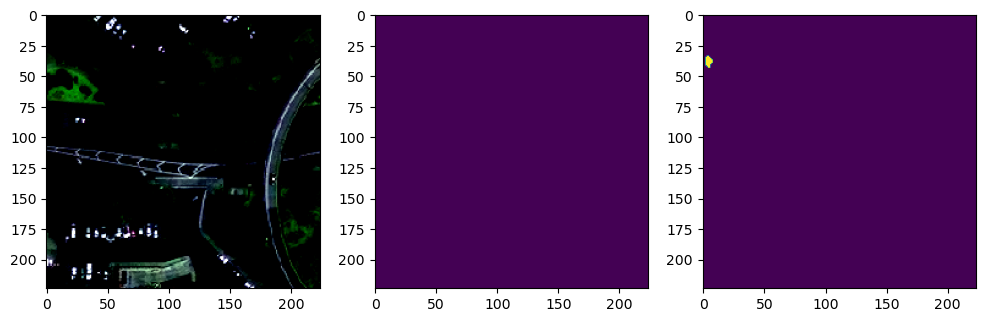

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


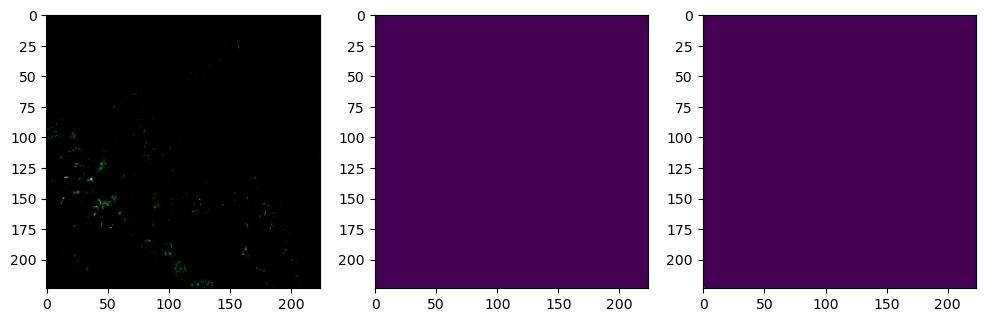

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


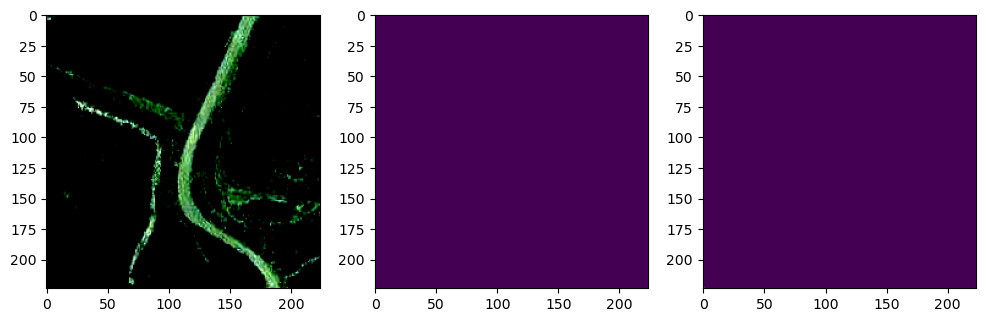

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


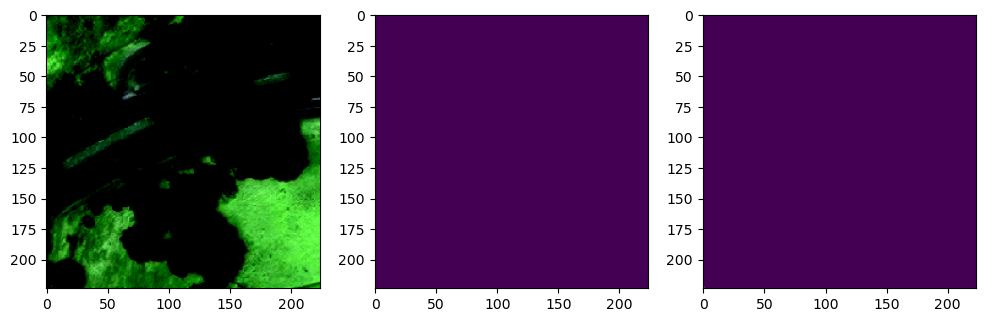

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


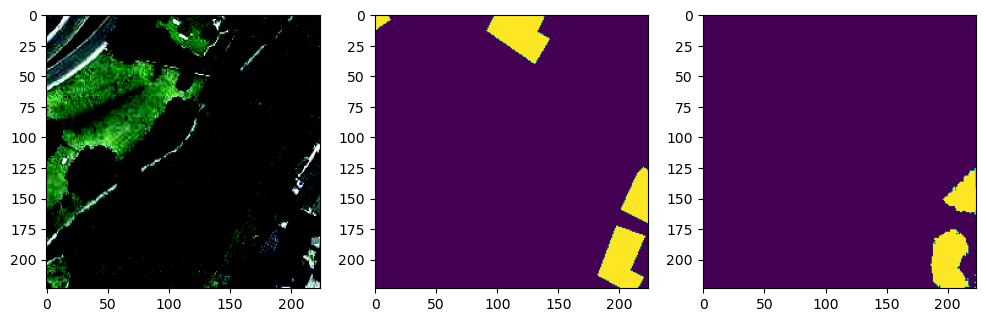

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


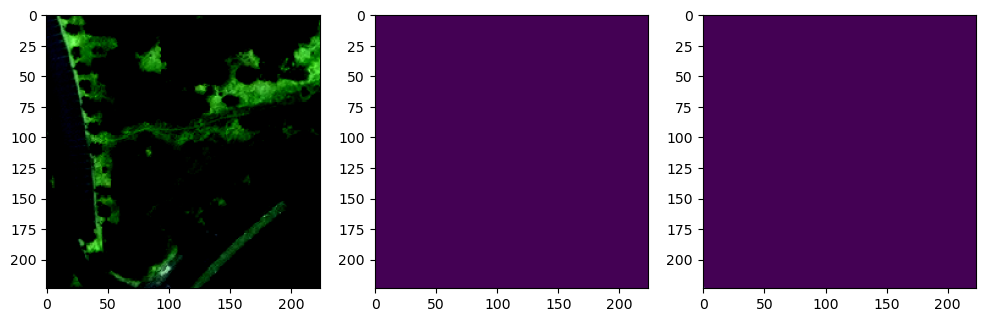

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


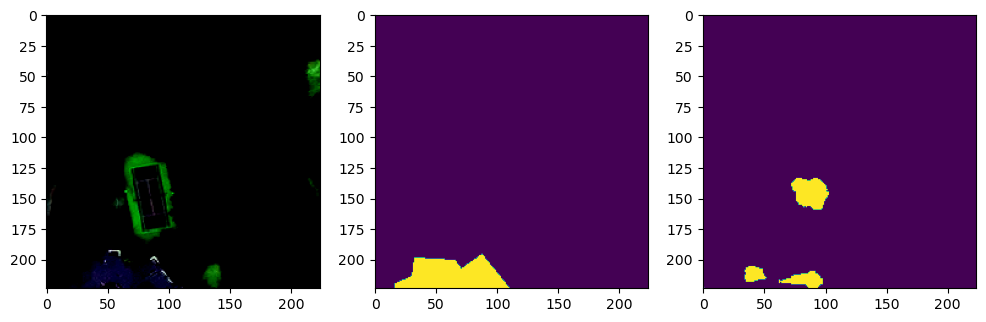

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


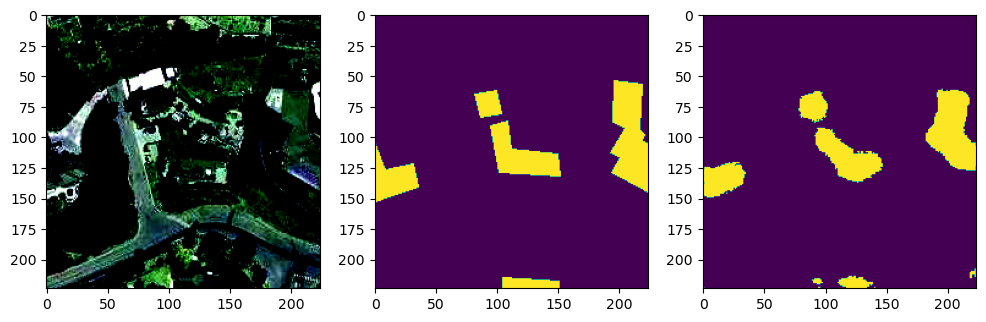

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


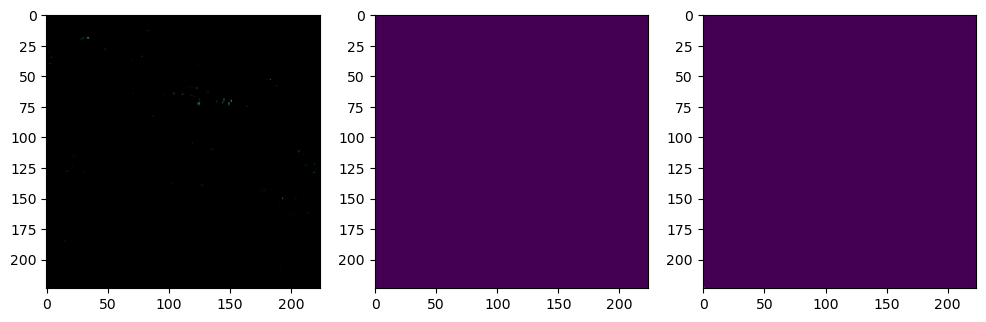

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


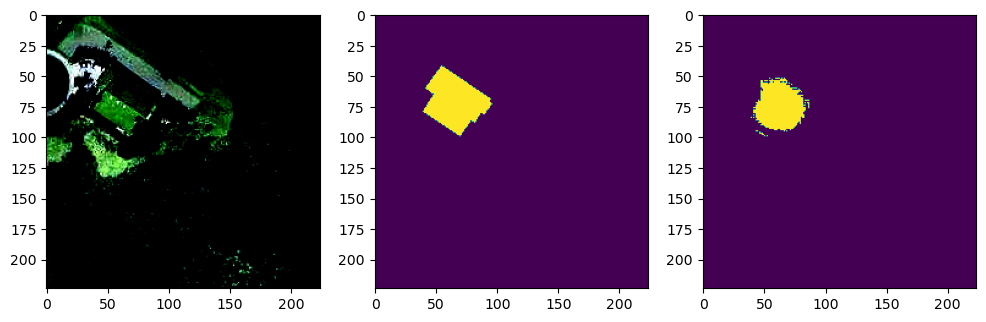

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


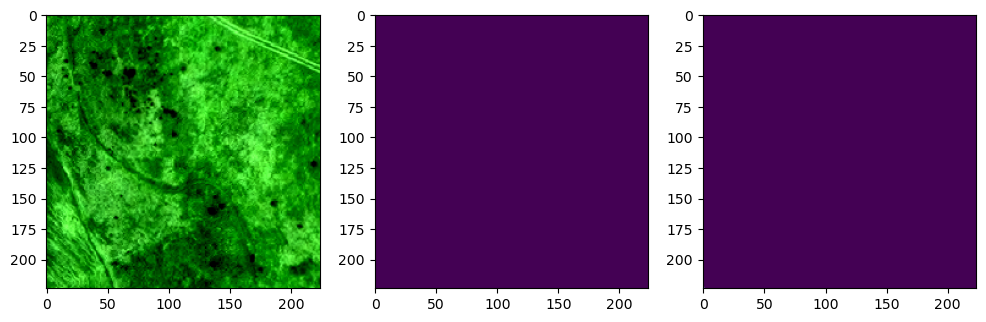

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


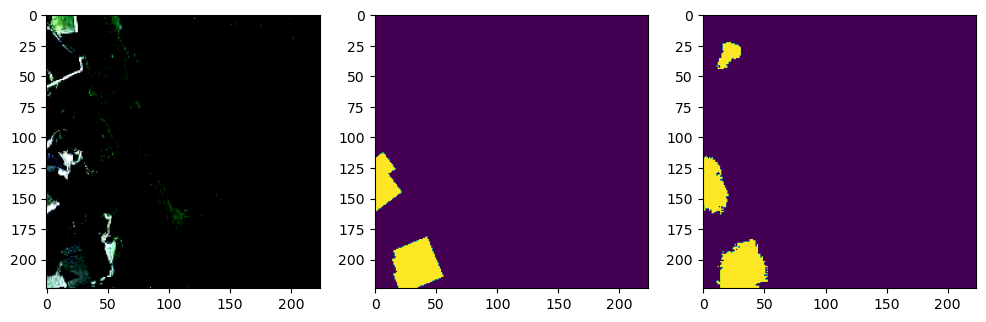

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


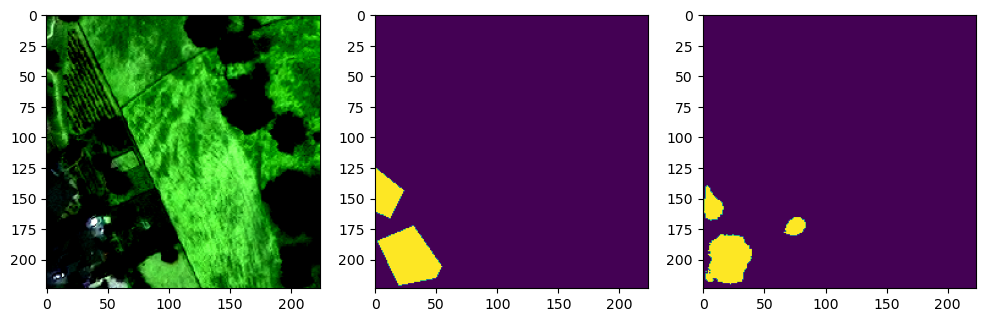

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


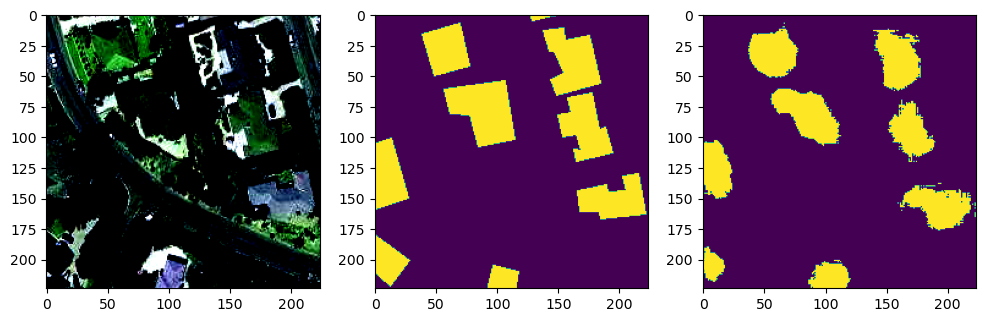

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


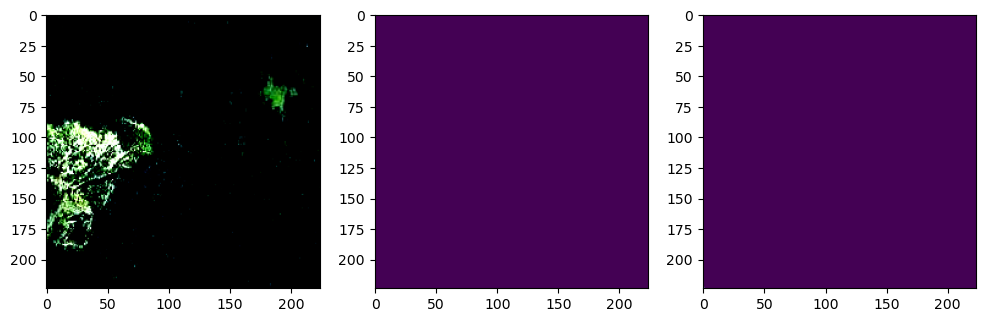

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


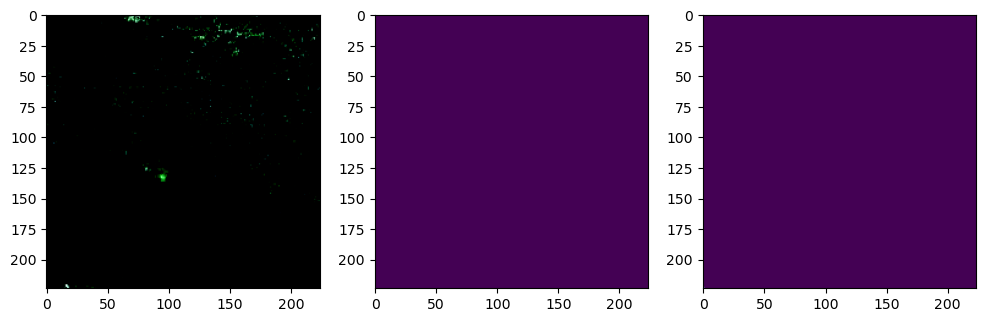

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


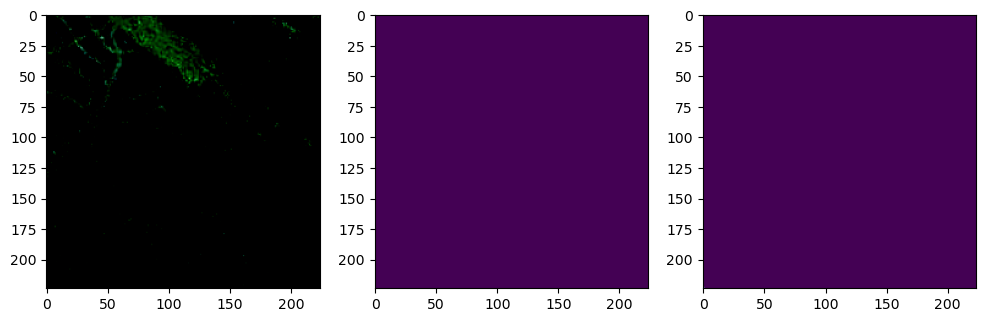

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


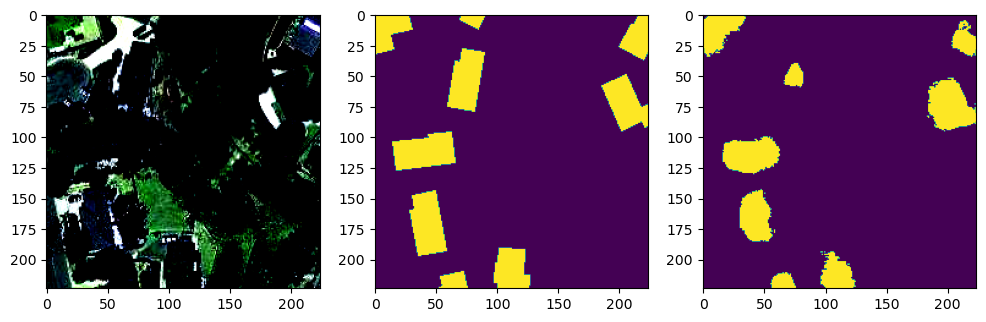

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


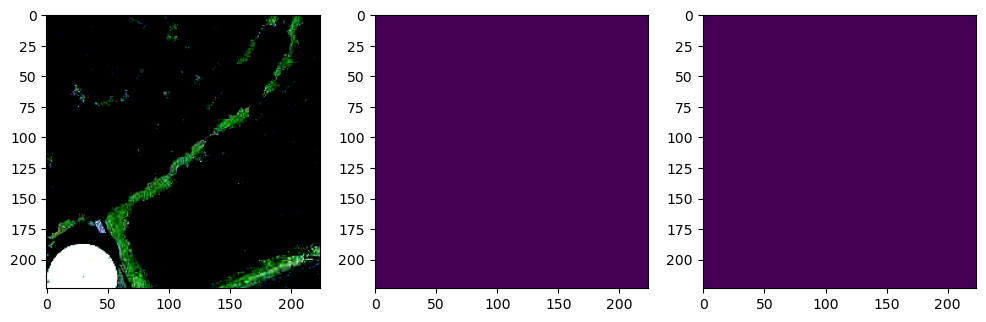

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


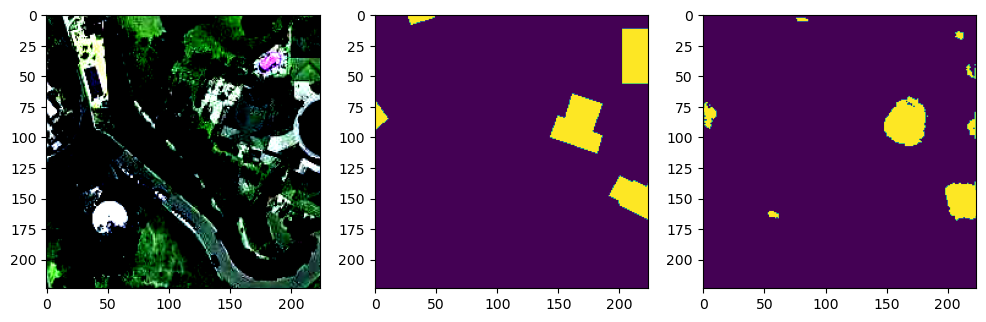

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


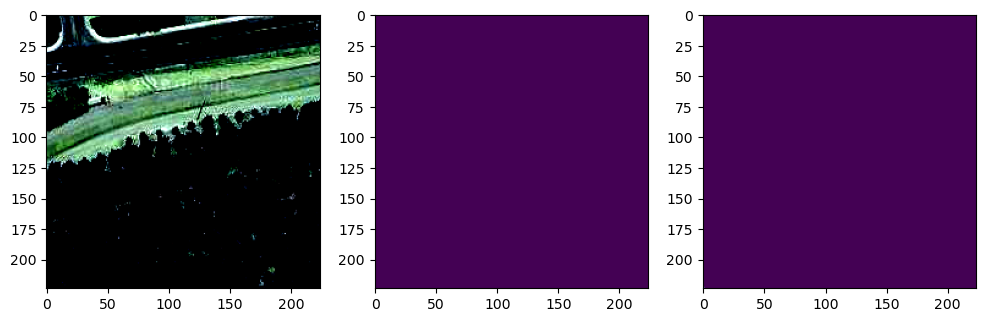

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


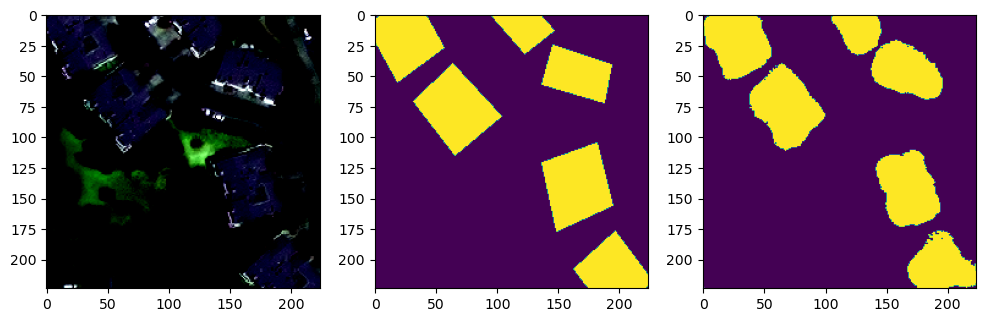

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


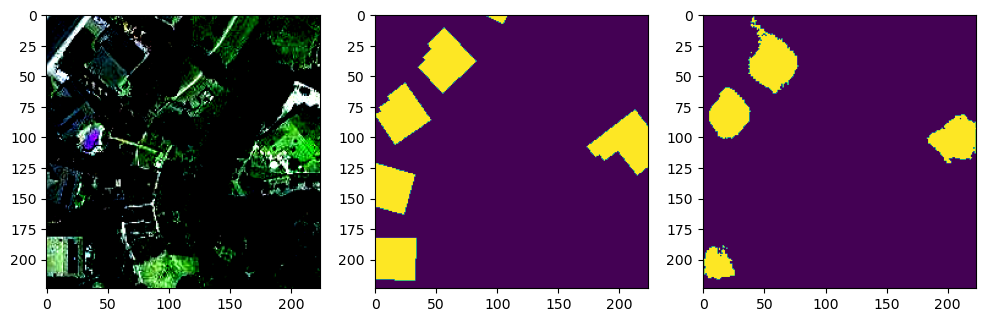

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


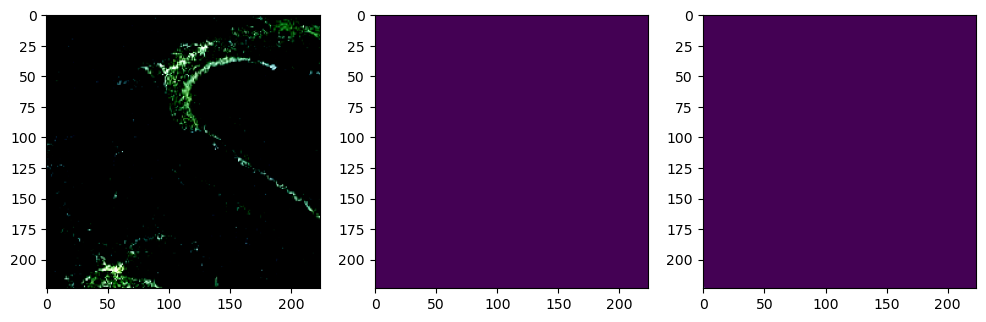

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


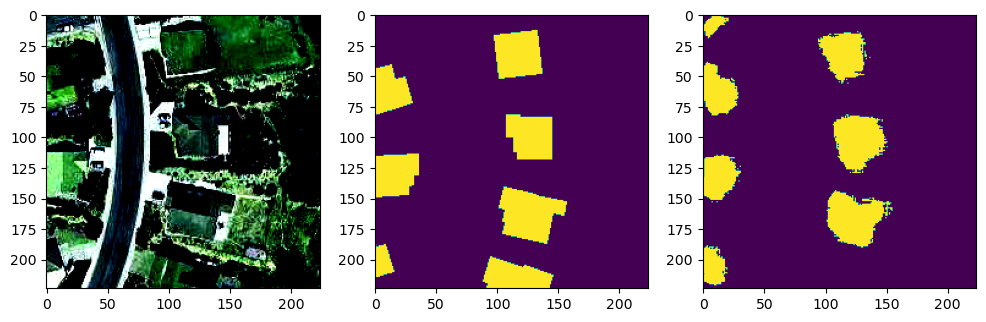

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


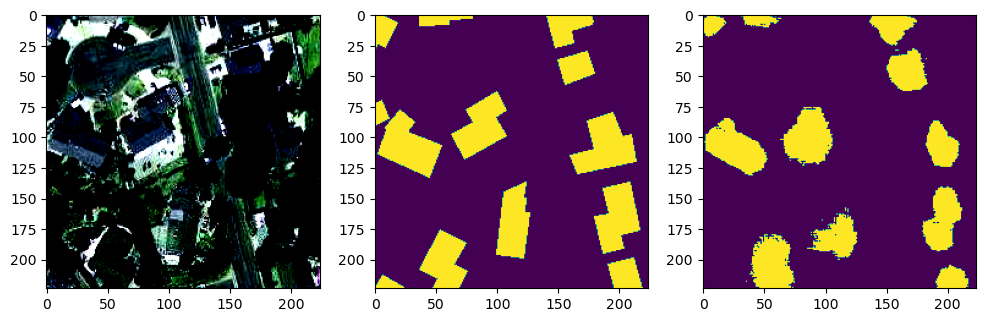

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


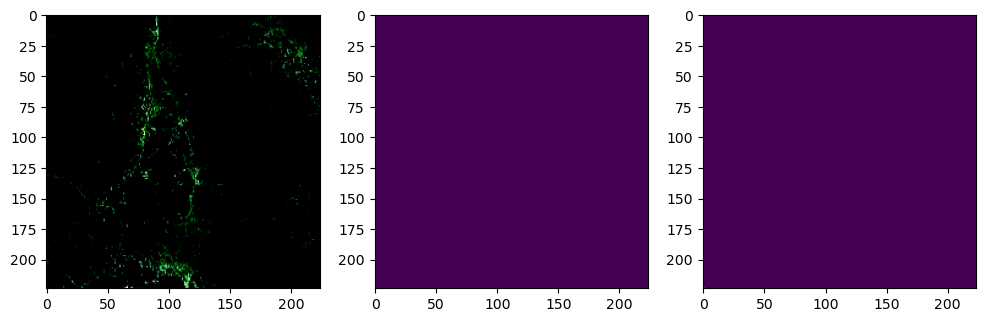

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


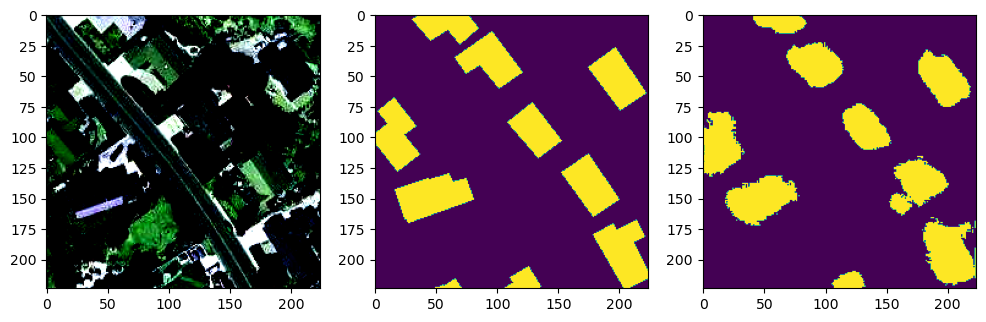

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


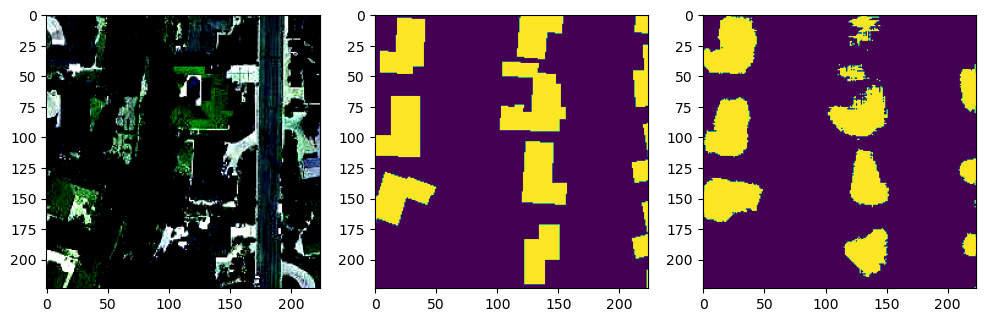

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


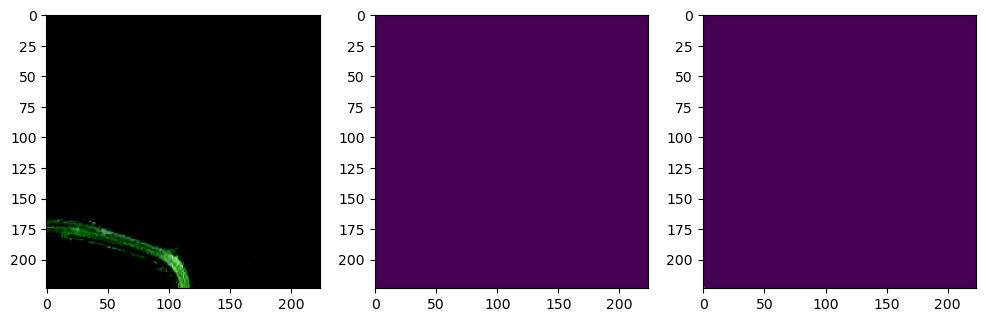

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


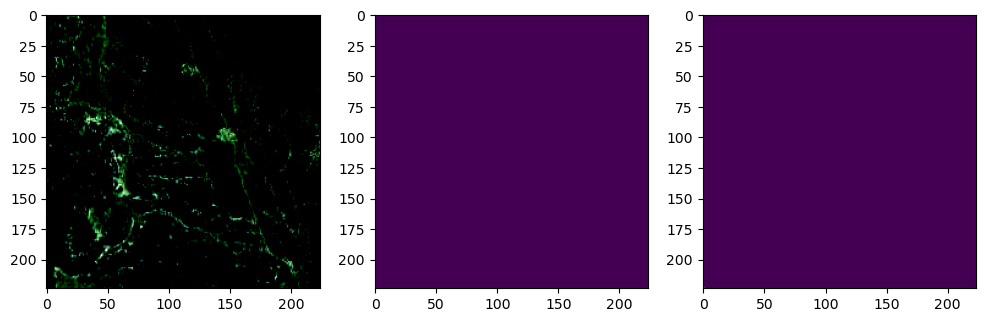

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


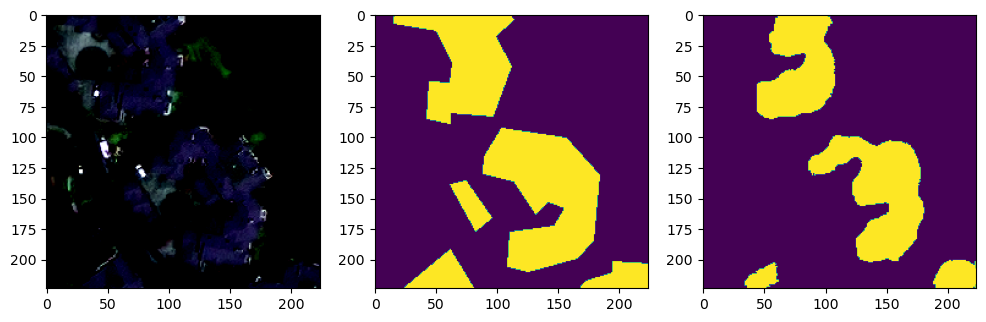

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


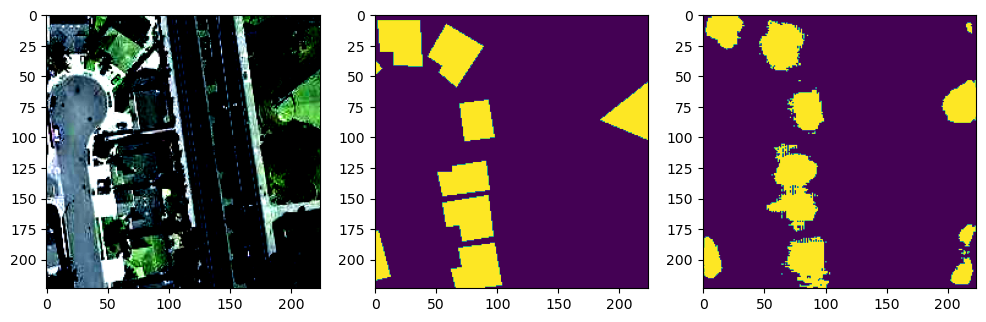

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


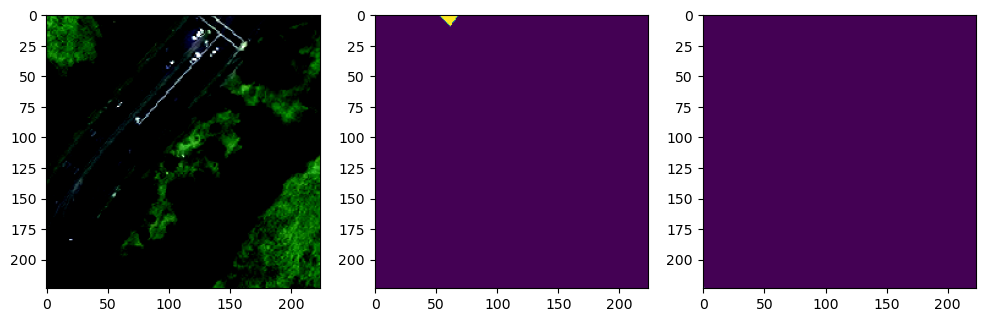

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


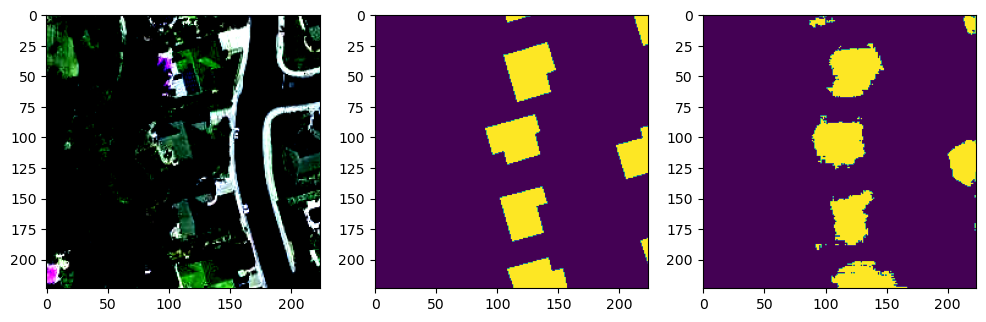

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


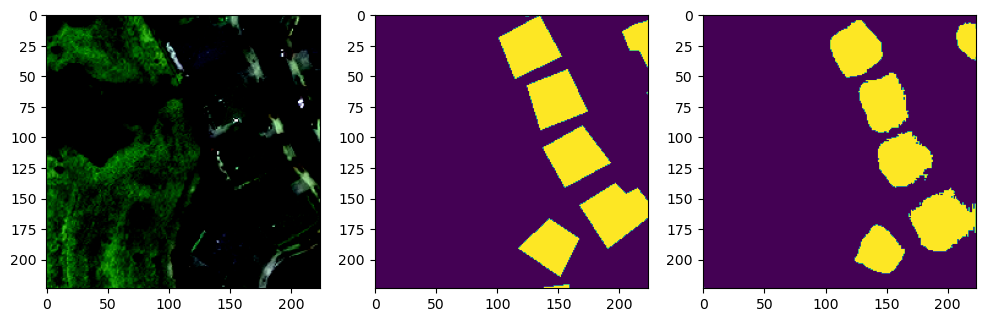

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


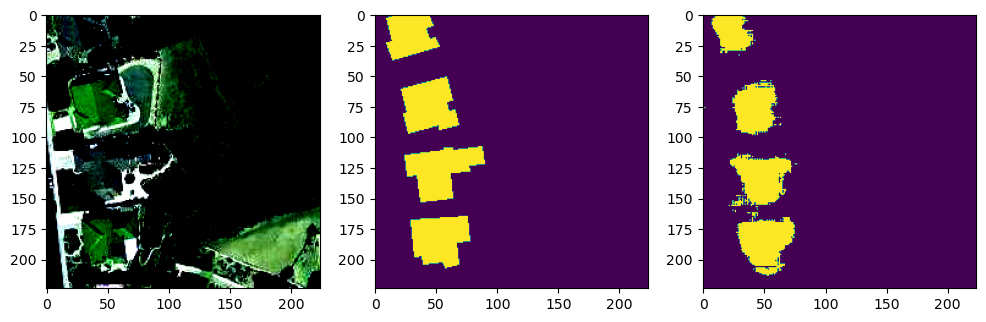

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


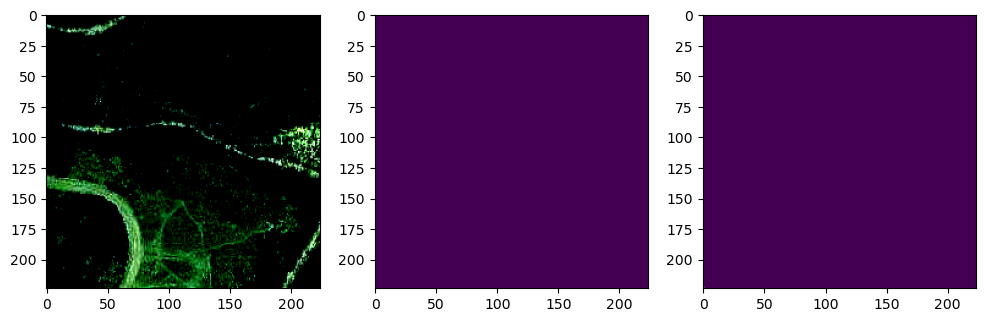

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


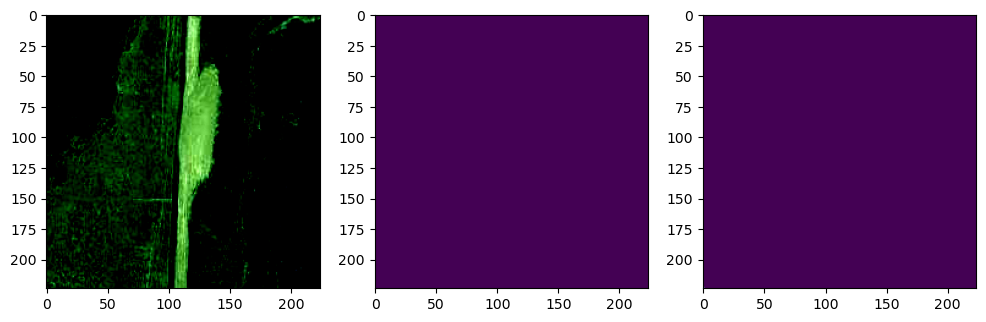

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


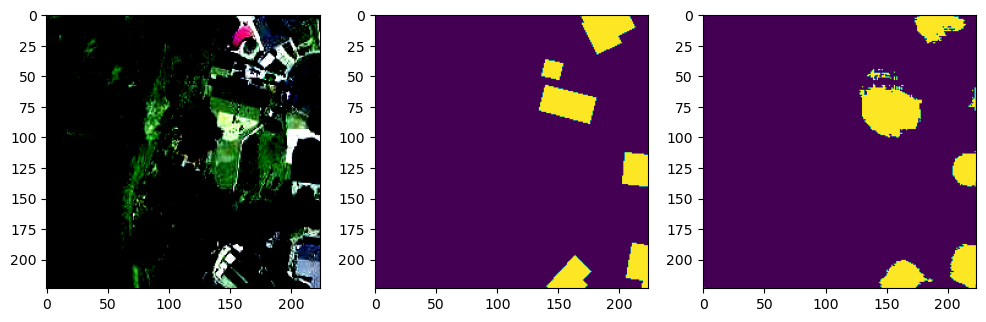

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


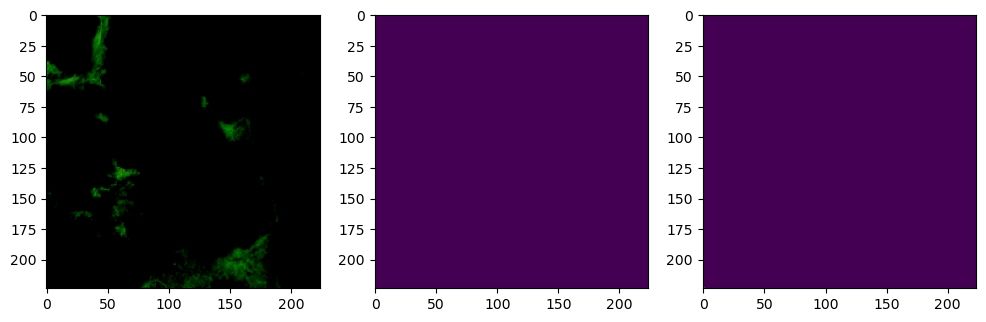

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


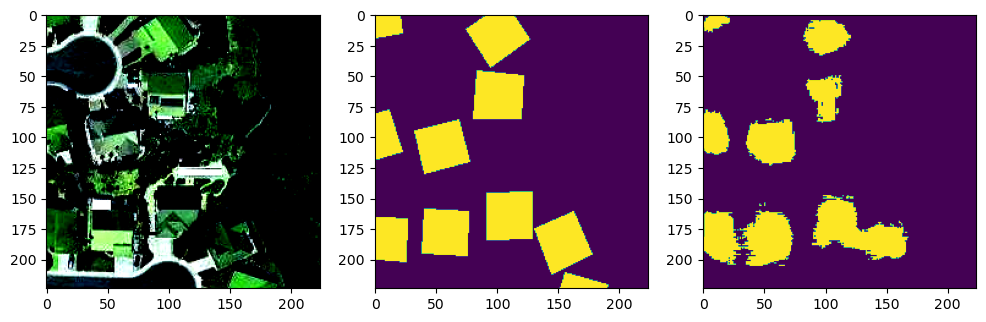

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


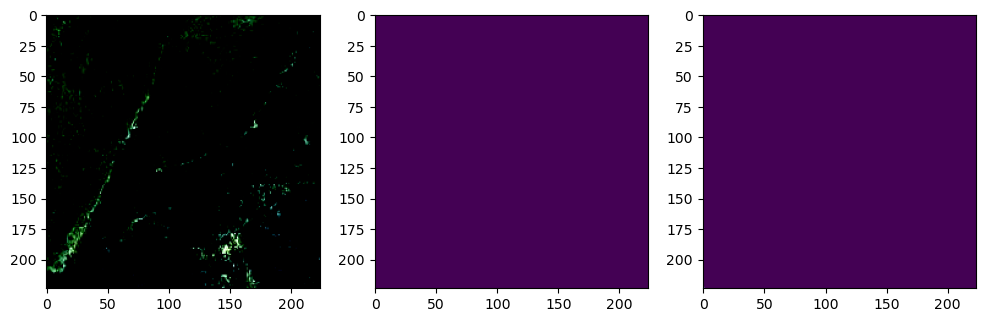

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


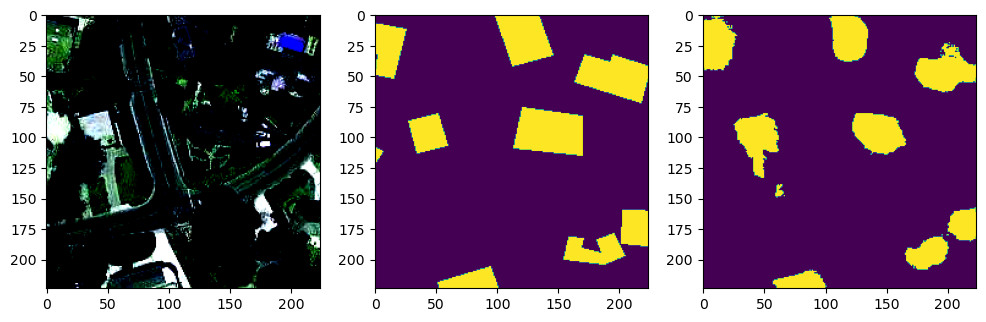

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


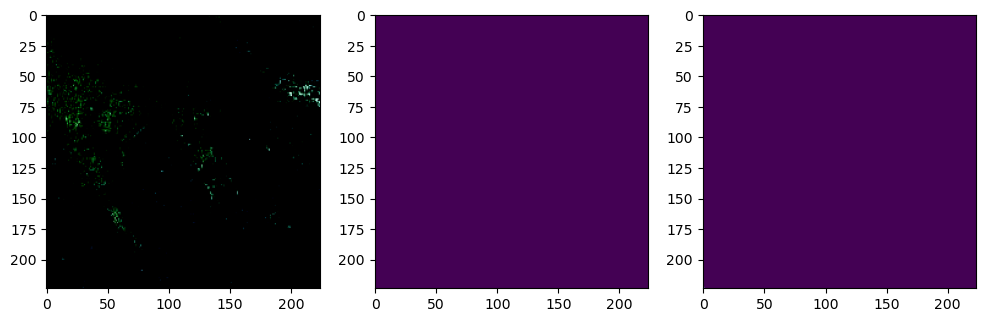

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


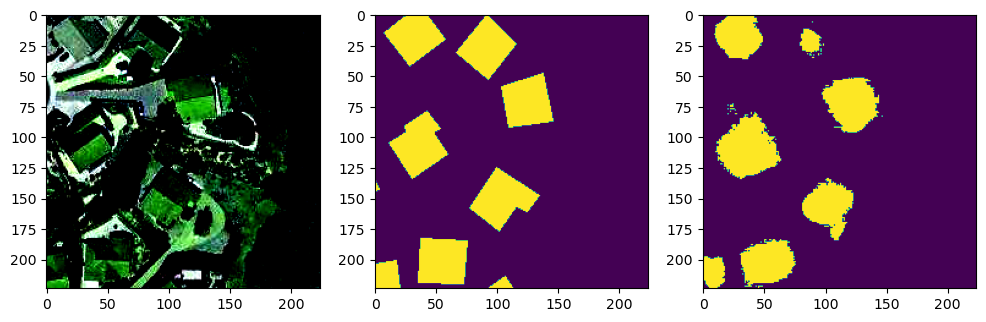

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


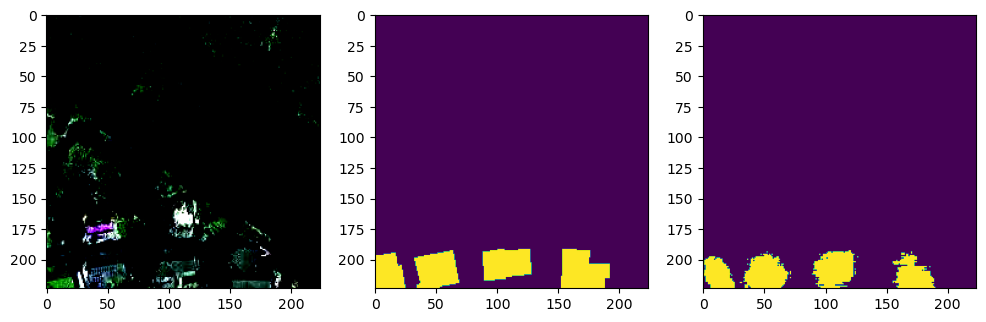

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


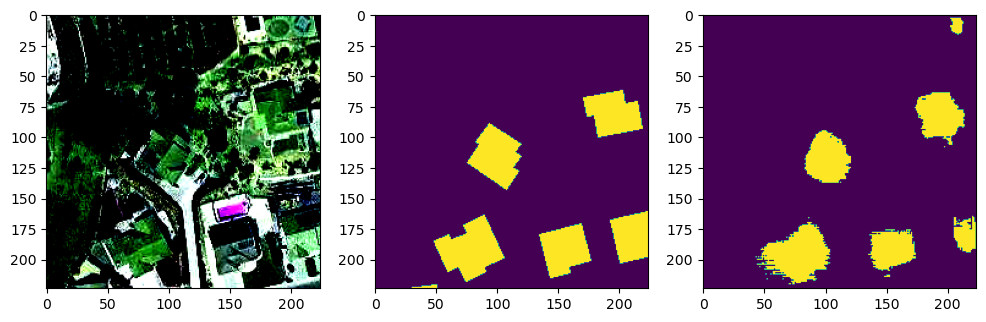

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


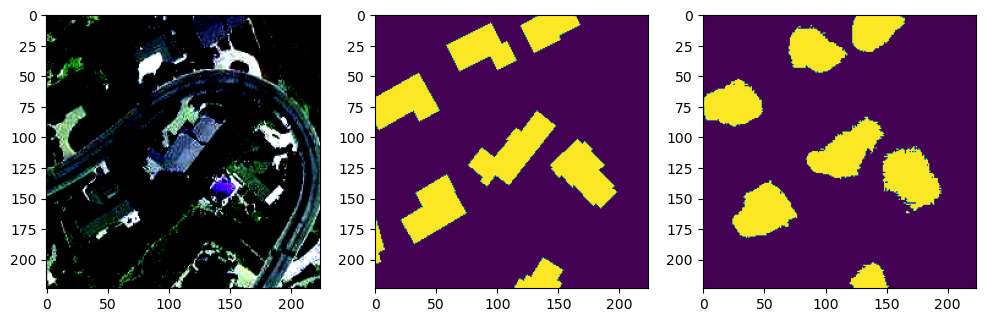

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


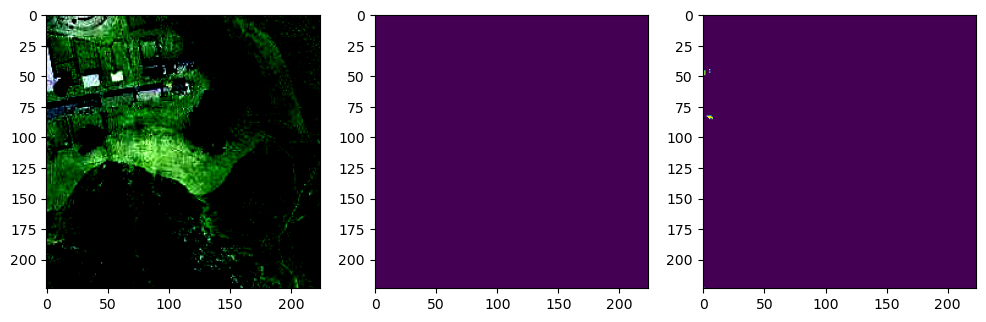

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


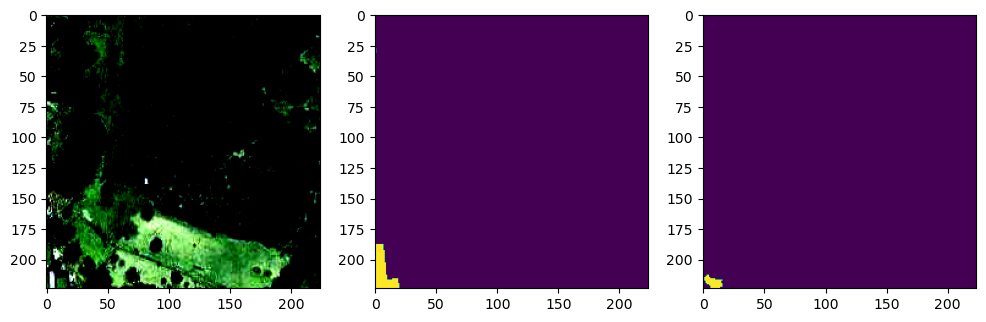

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


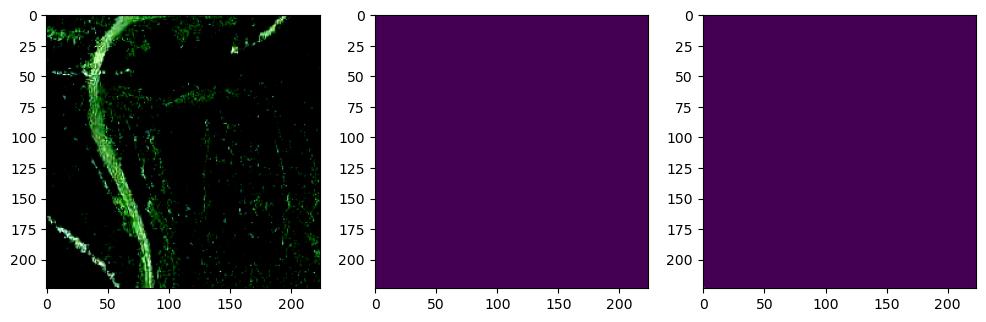

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


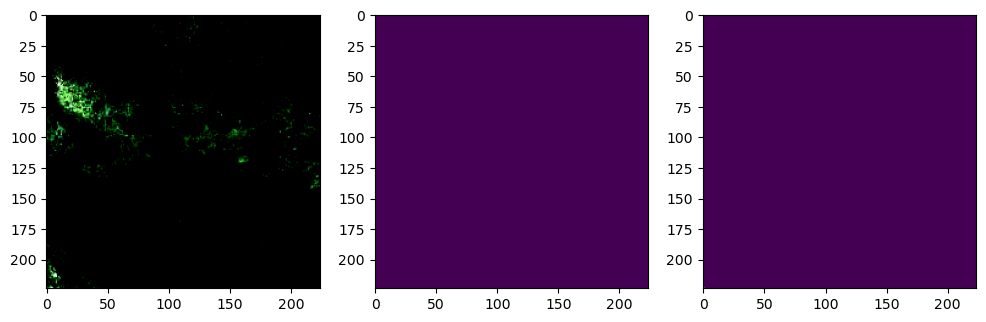

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


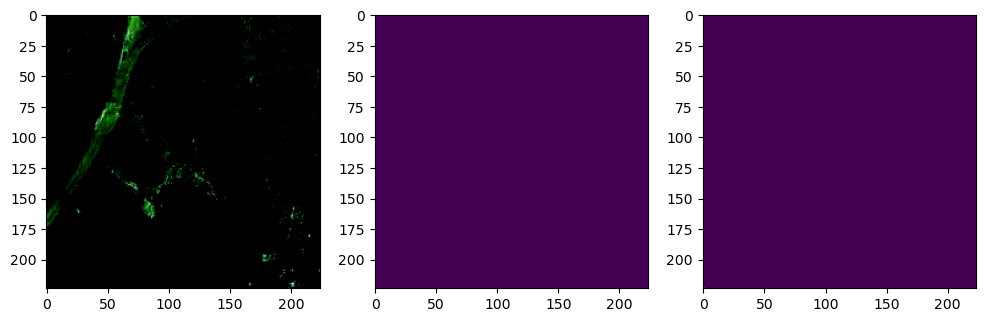

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


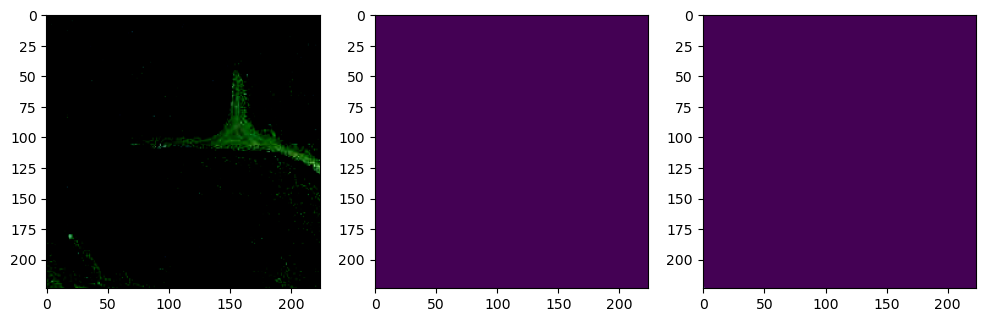

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


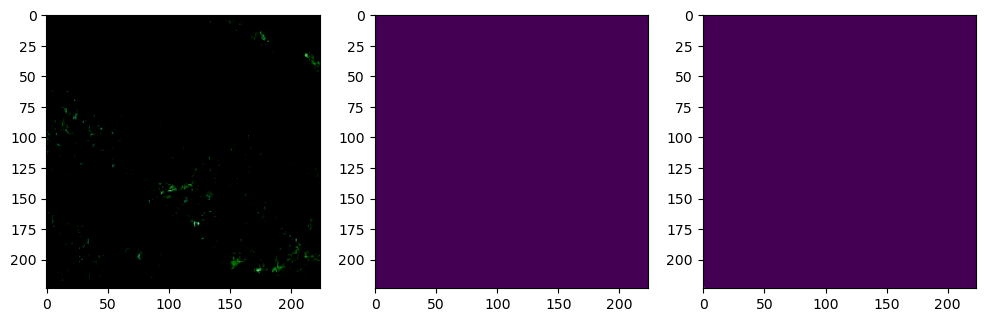

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


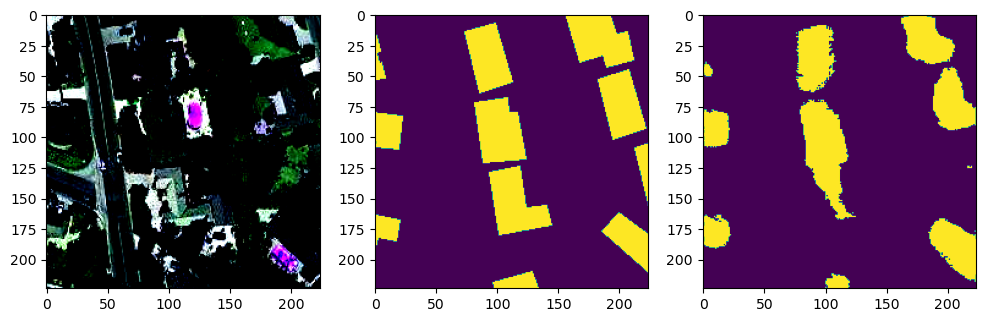

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


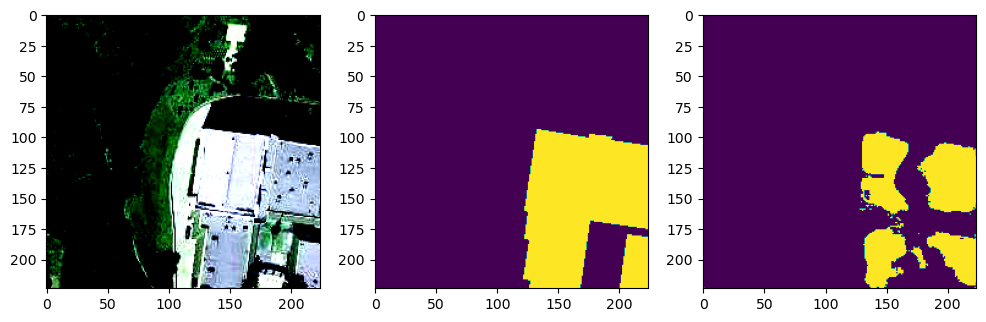

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


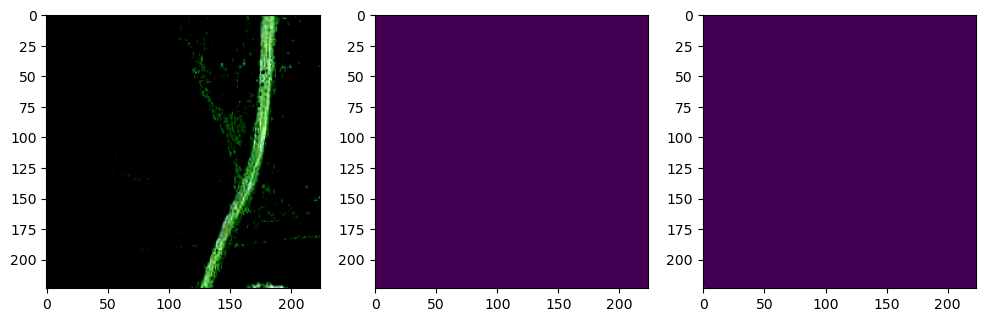

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


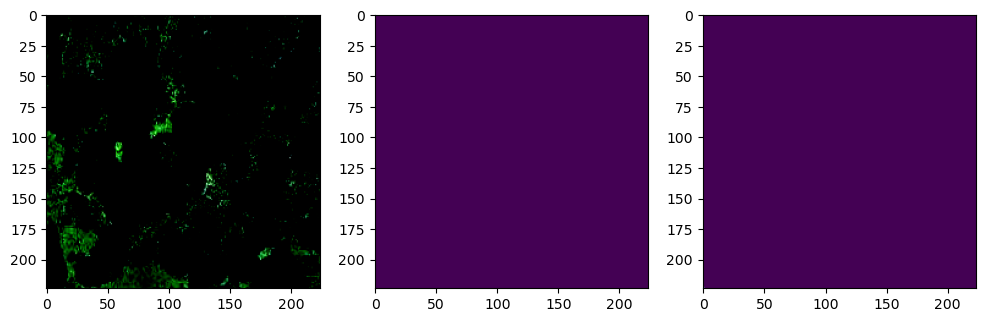

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


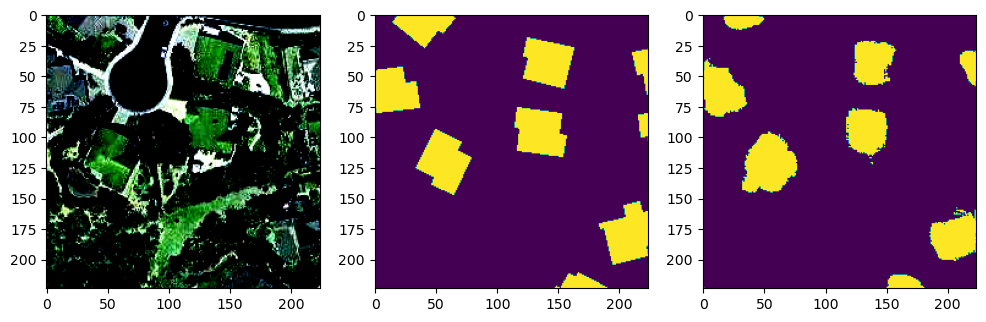

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


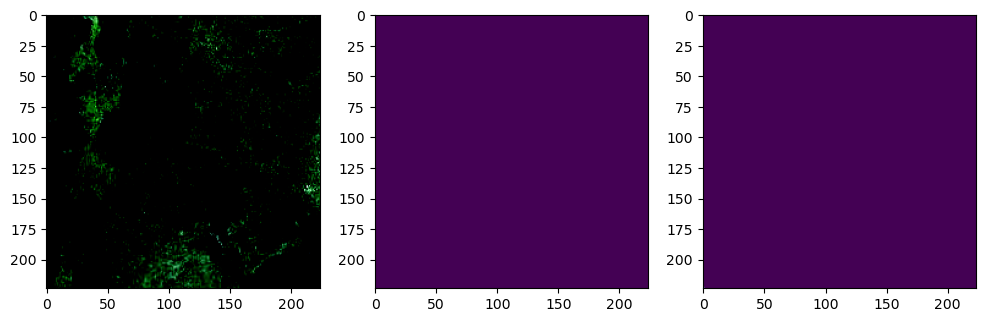

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


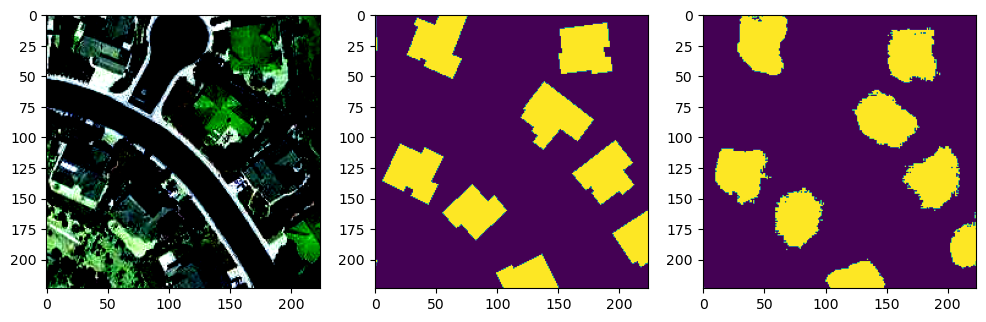

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


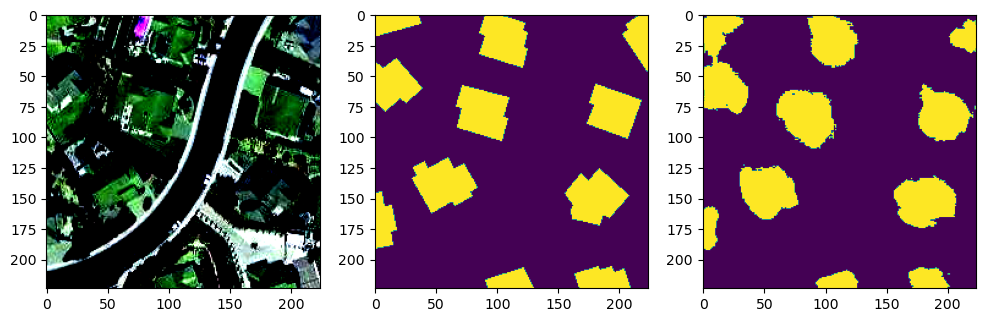

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


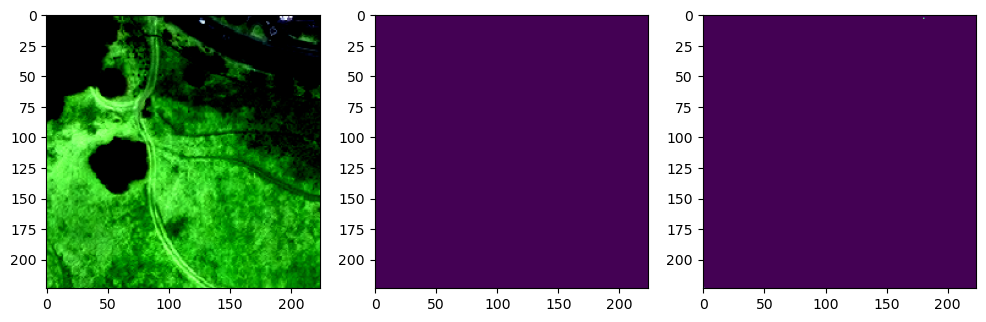

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


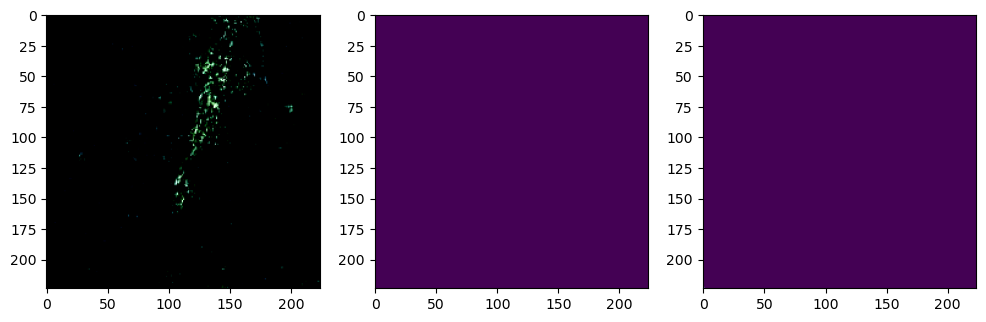

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


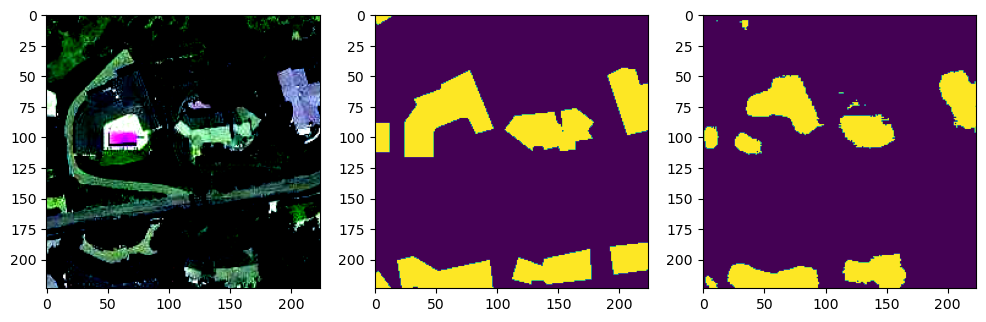

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


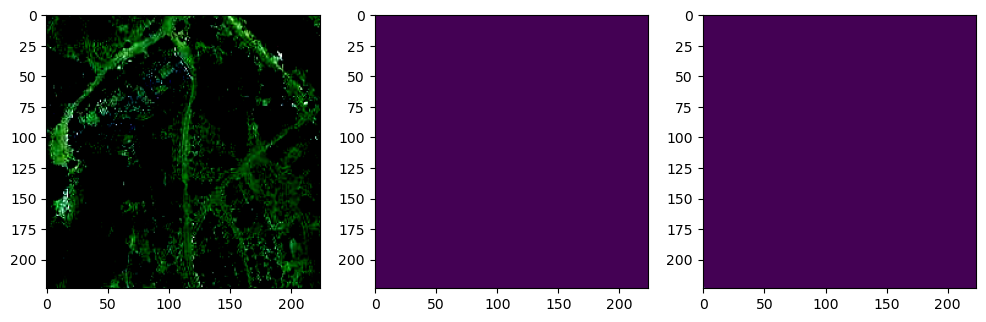

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


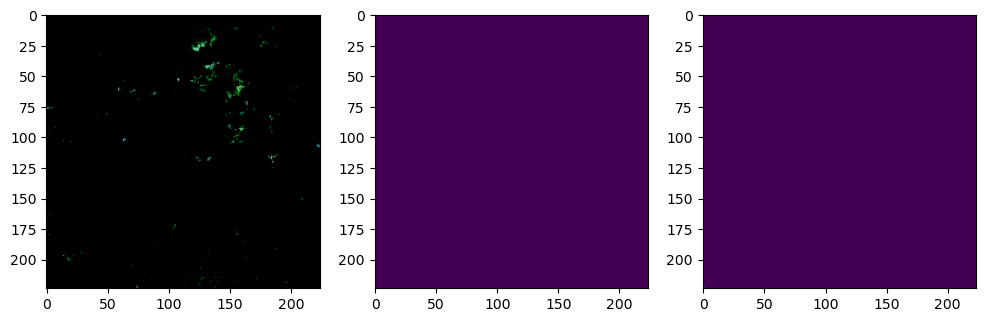

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


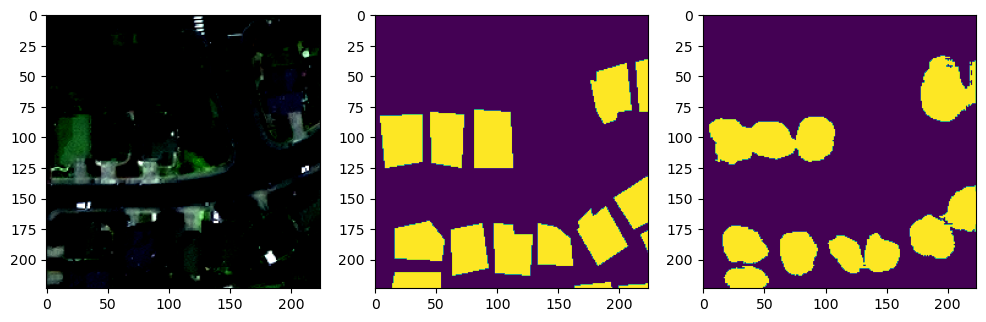

In [82]:
best_model.eval()
for batch_i, (x, y, _, _) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = best_model(x.to(device)[j:j+1])
        
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        
        plt.figure(figsize=(12,12))

        plt.subplot(1,3,1)
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        plt.imshow(im)
        
        gt_mask = y[j]
        plt.subplot(1,3,2)
        plt.imshow(gt_mask.permute(1, 2, 0).numpy())

        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
        plt.subplot(1,3,3)
        plt.imshow(mask[np.newaxis, :].transpose(1, 2, 0))
        plt.show()